## <font color='green'> <div align="center">In the name of God </div></font>

### <font color='red'> Author: Sayed Kamaledin Ghiasi-Shrirazi <a href="http://profsite.um.ac.ir/~k.ghiasi">(http://profsite.um.ac.ir/~k.ghiasi)</a> </font>

# Comparing running time of traditional and the novel <font color='red'>svd</font> solvers for Fisher LDA

##### Importing general modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import sklearn
import scipy.stats as st
import time
import matplotlib as mpl

##### Importing modules wtitten by the author

In [2]:
from LinearDiscriminantAnalysis import LinearDiscriminantAnalysis
from LDATrainingDataPreparation import TrainingData

##### Defining a function for generating N samples of dimension dim

The data comes from a 2-class classification problem, where each class consists of 3 clusters.
Samples are drawn from Gaussian distributions with a specific covariance matrix.
Here, I have generated samples without **np.random.multivariate_normal** to speedup dataset generation.

In [3]:
def prepareDataset (N, dim):
    nClasses = 3
    nClusters = 1
    theta = np.pi / 4
    p3 = 1 / 3
    p2 = 1 / 3
    p1 = 1 / 3
    Ki = np.array([1, 1, 1], dtype=int)
    NKi = np.array([[p1 * N], [p2 * N], [p3 * N]], dtype=int)
    position = np.array([[[0, -1]], [[0, 0]], [[0, 1]]])

    R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    means = np.zeros([nClasses, nClusters, dim])
    for i in range(nClasses):
        for j in range(nClusters):
            x, y = position[i, j]
            m = R @ np.sqrt(np.diag([1, 4])) @ np.array([x, y]) * 5 / np.sqrt(2)
            means[i, j, 0] = m[0]
            means[i, j, 1] = m[1]
            means[i, j, 2:] = 0

    scales = [0.25, 9]
    S = np.diag(scales)
    cov2 = R @ S @ R.T
    cov = np.zeros([dim, dim])
    cov[0:2, 0:2] = cov2
    for i in range(2, dim):
        cov[i, i] = scales[0]

    N = np.sum (NKi)
    XTrain = np.zeros ([N, dim])
    yTrain = np.zeros (N)
    idx = 0
    for i in range (nClasses):
        for j in range(nClusters):
            Xi_first = np.random.multivariate_normal (np.zeros(2), cov2, NKi[i, j])
            Xi_rest = np.random.randn(NKi[i, j], dim-2)
            Xi_rest *= scales[0]
            Xi = np.hstack([Xi_first,Xi_rest])
            Xi += means[i,j,:]            
            #Xi = np.random.multivariate_normal (means[i,j,:], cov, NKi[i, j])
            XTrain[idx:idx + NKi[i, j], :] = Xi
            yTrain[idx:idx + NKi[i, j]] = i
            idx += NKi[i, j]

    yTrain = np.array(yTrain, dtype='int')

    td = TrainingData(XTrain, yTrain)
    td.setSubclasses(Ki, NKi)
    return td, means

##### Depicting the distribution of data

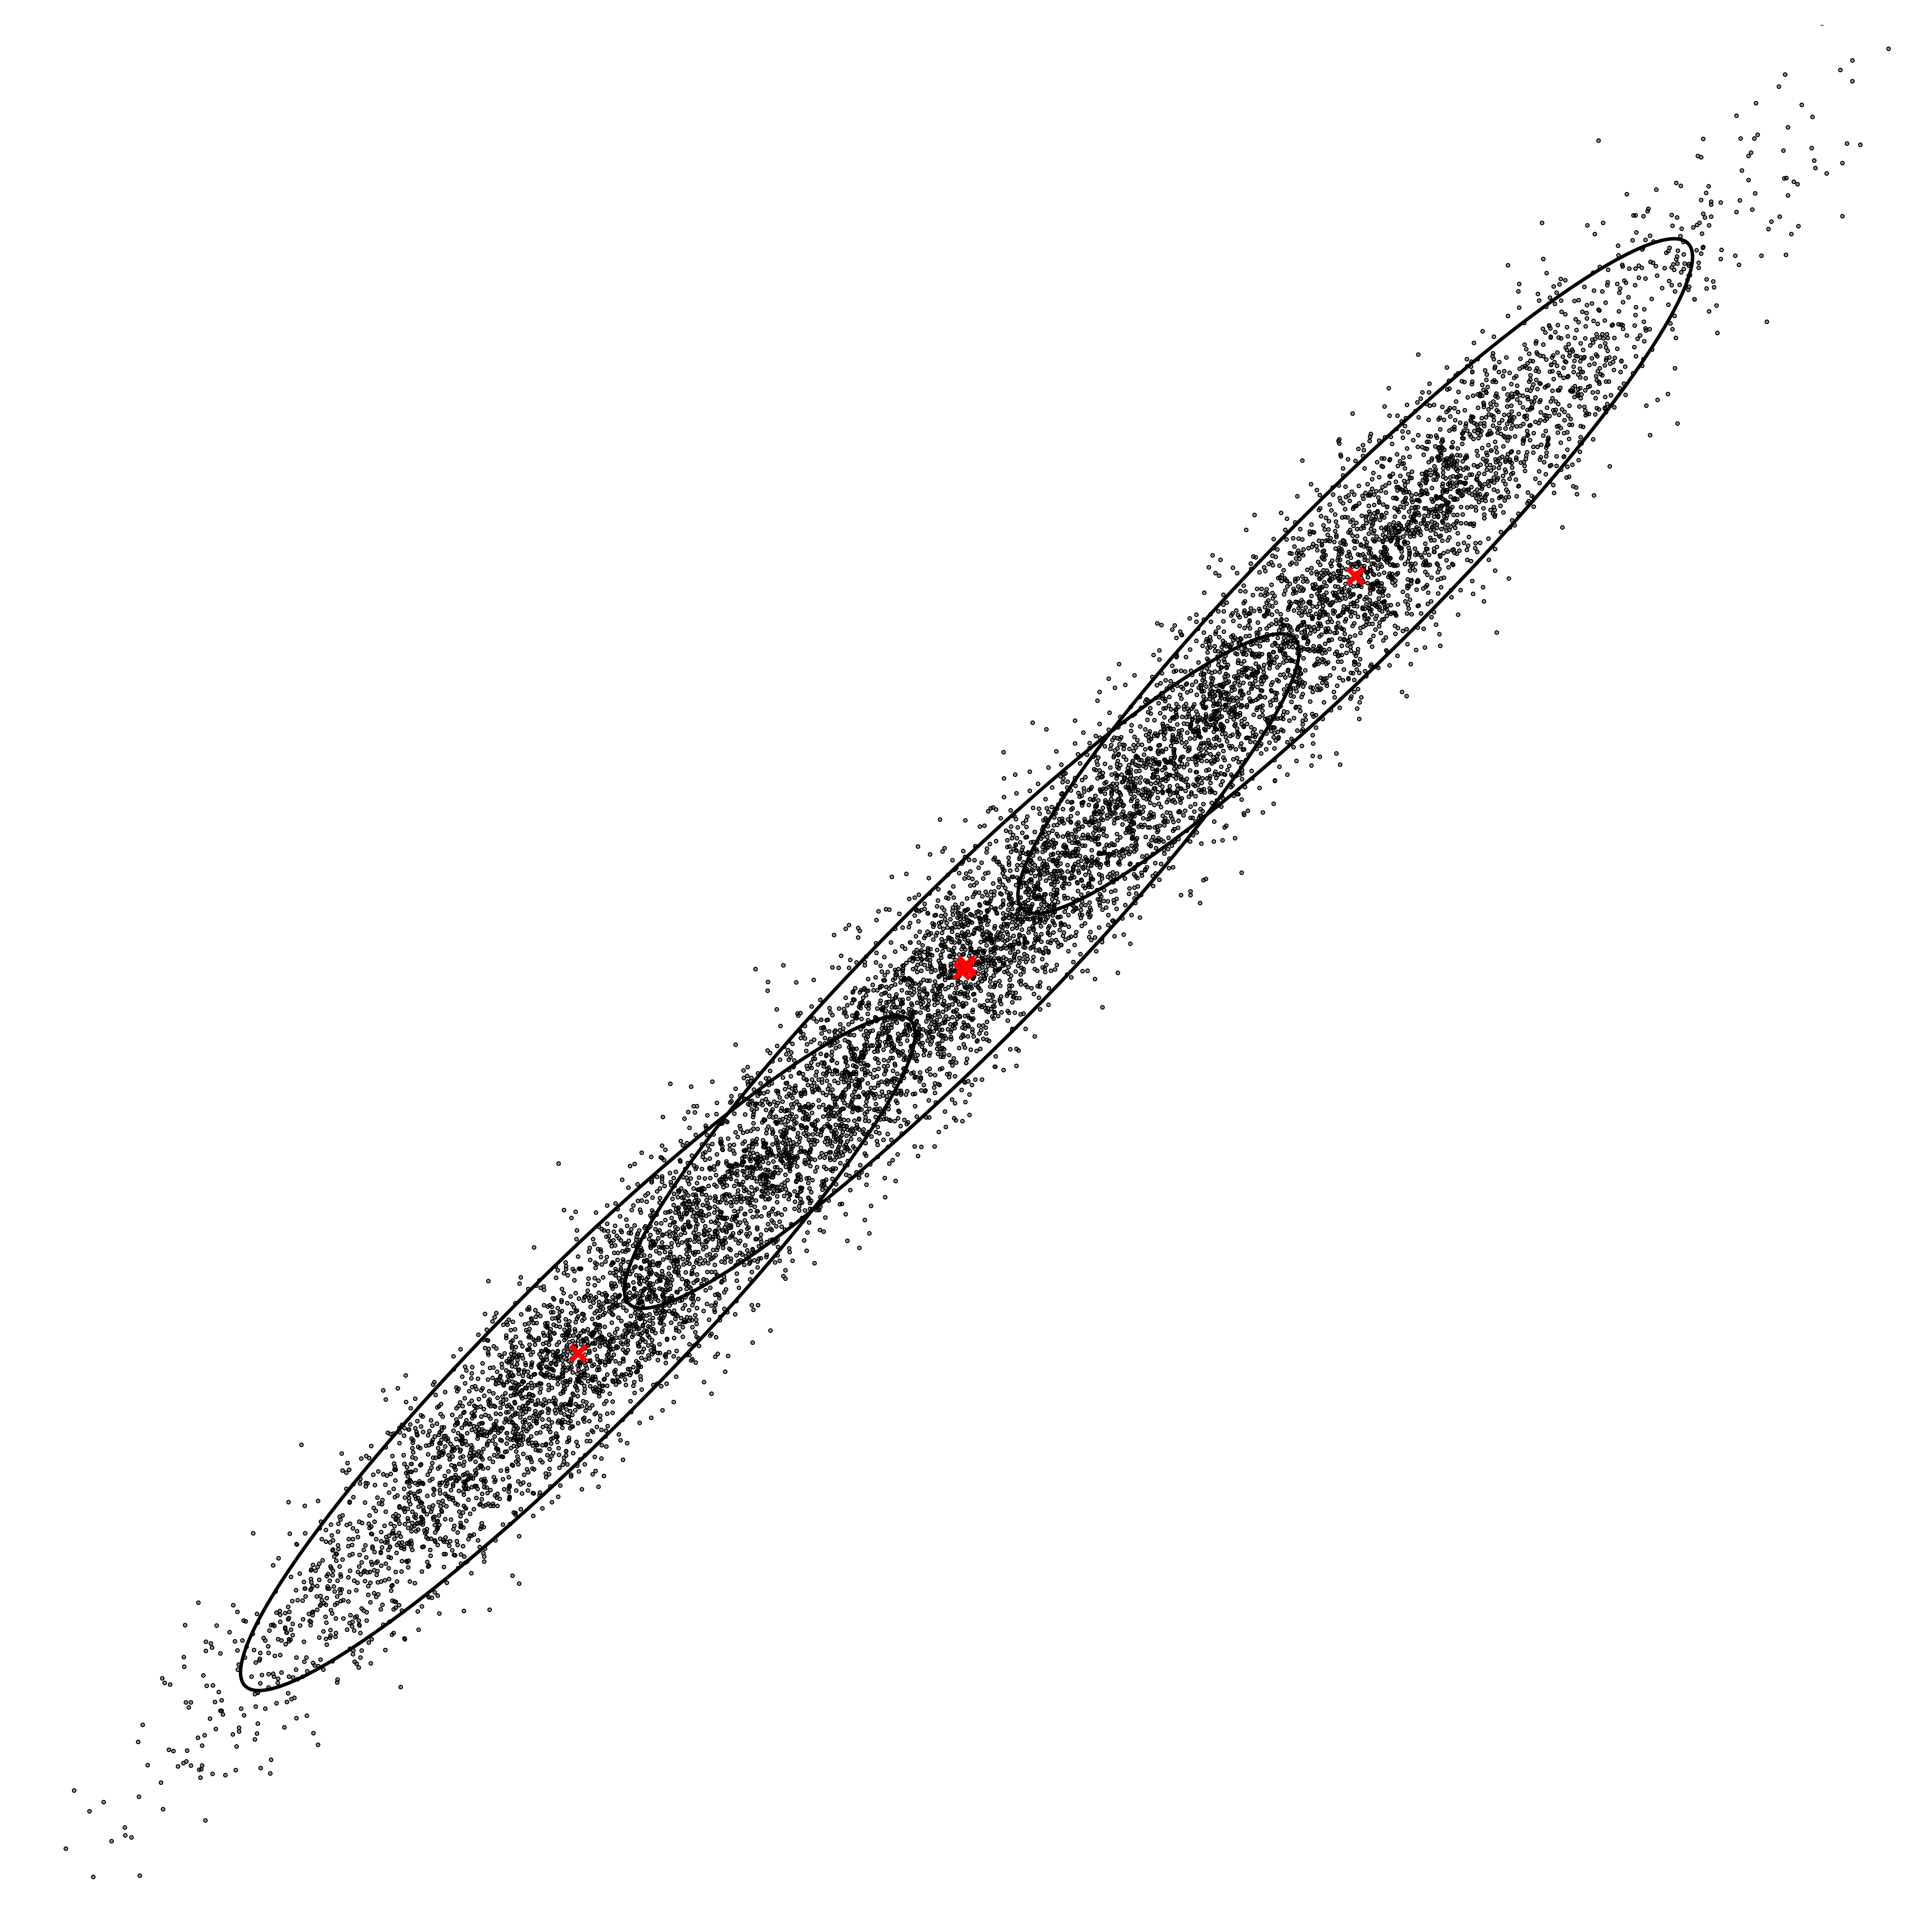

In [4]:
td, means = prepareDataset (10000, 128)
nClasses = 3
nClusters = 1
scales = [0.25, 9]
%matplotlib inline
mpl.rcParams['figure.dpi']= 600
plt.figure(figsize=[10,10])
ax = plt.subplot(111, aspect='equal')
color_map = np.array(['blue', 'green', 'black'])
plt.scatter(td.X[:, 0], td.X[:, 1], s=0.1, c='black')
means_computed = td.subclassMeans.reshape([-1,2])
plt.scatter(means_computed[:,0], means_computed[:,1], s=20, marker='x', c='red')
s = 4
for i in range (nClasses):
    for j in range(nClusters):
        width = np.sqrt(scales[0]) * s
        height = np.sqrt(scales[1]) * s
        e = Ellipse(td.subclassMeans[i,j,:], width, height, -45, facecolor = 'none', edgecolor = 'k')
        ax.add_artist(e)
plt.xlim(-12, 12)
plt.ylim(-12, 12)
plt.axis('off')
plt.show()

##### Defining a function for measuring running time of a solver on a dataset.

In [5]:
def performExperiment(td, solver, metric_learning):
    lda = LinearDiscriminantAnalysis(td, solver, metric_learning, 'Sb', 'St', 0.01, 0.0001)

    start = time.time()
    # I set normalize to Falase, so that EIG-LDA++ solution can be computed based on LDA++
    lda.fitFeatureExtractor(normalize = False)
    end = time.time()
    obj = lda.objective()
    return end - start, obj, lda

##### Performing experiments on N=100 samples with different dimensions

In [6]:
#Small Sample Size
N = 900
rep = 5
runtimeTable = np.zeros([3,16-10, rep])
objTable = np.zeros([3,16-10, rep])
for r in range (rep):
    for logDim in range(10,16):
        i = logDim - 10
        dim = 2 ** logDim
        td, means = prepareDataset (N, dim)

        solver = 'svd'
        # metric_learning could be always 'eig'. But I want to be clear that it only applies to LDA++
        metric_learning = ''
        runTime, obj, _ = performExperiment (td, solver, metric_learning)
        print ('For solver {:>15}, N = {}, dim = {} runtime is {:.4f}, objective = {:.4f}'.format(solver, N, dim, runTime, obj))
        runtimeTable[0,i, r] = runTime
        objTable[0,i, r] = obj  

        solver = 'ghiasi_svd'
        metric_learning = 'none'
        runTime, obj, lda = performExperiment (td, solver, metric_learning)
        print ('For solver {:>15}, metric_learning {}, N = {}, dim = {} runtime is {:.4f}, objective = {:.4f}'.format(solver, metric_learning, N, dim, runTime, obj))
        runtimeTable[1,i, r] = runTime
        objTable[1,i, r] = obj    

        #inaccurate method:
            #solver = 'ghiasi_svd'
            #metric_learning = 'eig'
            #runTime, obj = performExperiment (td, solver, metric_learning)
            #print ('For solver {:>15}, metric_learning {}, N = {}, dim = {} runtime is {:.4f}, objective = {:.4f}'.format(solver, metric_learning, N, dim, runTime, obj))
            #runtimeTable[2,i, r] = runTime + metric_learning_time
            #objTable[2,i, r] = obj
        
        start = time.time()
        for _ in range (100):
            A = lda.model
            Q = np.diag(lda.Li / np.sum(lda.Li))
            B = Q @ lda.Mi @ A.T
            (eigvalsZ, Z) = np.linalg.eig(B)
            idx = eigvalsZ.argsort()[::-1]
            Z = Z[:,idx]
            eigvalsZ = eigvalsZ[idx]
            # Since we extract L features, Z is singular.
            # However, it should not have more than one zero eigenvalue.
            # Otherwise the objective function would decrease.
            if eigvalsZ[-2] > 1e-12:
                A = Z.T @ A
            else:
                print ('Z not applied.')        
        end = time.time()
        metric_learning_time = (end - start) / 100
        
        print ('For solver {:>15}, metric_learning {}, N = {}, dim = {} runtime is {:.4f}, objective = {:.4f}'.format(
                                                solver, metric_learning, N, dim, runTime + metric_learning_time, obj))
        runtimeTable[2,i, r] = runTime + metric_learning_time
        objTable[2,i, r] = obj
        print ('----------------------------------------------')

For solver             svd, N = 900, dim = 1024 runtime is 0.9400, objective = 1.6642
For solver      ghiasi_svd, metric_learning none, N = 900, dim = 1024 runtime is 0.9178, objective = 1.6642
For solver      ghiasi_svd, metric_learning none, N = 900, dim = 1024 runtime is 0.9180, objective = 1.6642
----------------------------------------------
For solver             svd, N = 900, dim = 2048 runtime is 1.3500, objective = 1.8787
For solver      ghiasi_svd, metric_learning none, N = 900, dim = 2048 runtime is 1.2343, objective = 1.8787
For solver      ghiasi_svd, metric_learning none, N = 900, dim = 2048 runtime is 1.2344, objective = 1.8787
----------------------------------------------
For solver             svd, N = 900, dim = 4096 runtime is 1.8201, objective = 1.9488
For solver      ghiasi_svd, metric_learning none, N = 900, dim = 4096 runtime is 1.8055, objective = 1.9488
For solver      ghiasi_svd, metric_learning none, N = 900, dim = 4096 runtime is 1.8057, objective = 1.9488


For solver             svd, N = 900, dim = 1024 runtime is 0.8332, objective = 1.6441
For solver      ghiasi_svd, metric_learning none, N = 900, dim = 1024 runtime is 0.7954, objective = 1.6441
For solver      ghiasi_svd, metric_learning none, N = 900, dim = 1024 runtime is 0.7954, objective = 1.6441
----------------------------------------------
For solver             svd, N = 900, dim = 2048 runtime is 1.2719, objective = 1.8727
For solver      ghiasi_svd, metric_learning none, N = 900, dim = 2048 runtime is 1.2810, objective = 1.8727
For solver      ghiasi_svd, metric_learning none, N = 900, dim = 2048 runtime is 1.2811, objective = 1.8727
----------------------------------------------
For solver             svd, N = 900, dim = 4096 runtime is 1.8589, objective = 1.9459
For solver      ghiasi_svd, metric_learning none, N = 900, dim = 4096 runtime is 1.8926, objective = 1.9459
For solver      ghiasi_svd, metric_learning none, N = 900, dim = 4096 runtime is 1.8926, objective = 1.9459


In [7]:
for logDim in range(10,16):
    d = 2 ** logDim
    i = logDim - 10
    print (d, '&',  '%0.4f'%np.mean(runtimeTable[0,i,:]), 
              '&', '%0.4f'%np.mean(runtimeTable[1,i,:]), 
              '&', '%0.4f'%np.mean(runtimeTable[2,i,:]), '\\\\')

1024 & 0.8183 & 0.8025 & 0.8026 \\
2048 & 1.2894 & 1.2649 & 1.2651 \\
4096 & 1.8723 & 1.8565 & 1.8567 \\
8192 & 3.2417 & 3.2404 & 3.2407 \\
16384 & 6.8361 & 6.7349 & 6.7354 \\
32768 & 14.3921 & 14.9536 & 14.9545 \\


In [13]:
for logDim in range(10,16):
    for r in range (rep):    
        d = 2 ** logDim
        i = logDim - 10
        print (d, '&',  '%0.4f'%objTable[0,i,r], '&', '%0.4f'%objTable[1,i,r], '&', '%0.4f'%objTable[2,i,r])

1024 & 1.6642 & 1.6642 & 1.6642
1024 & 1.6582 & 1.6582 & 1.6582
1024 & 1.6561 & 1.6561 & 1.6561
1024 & 1.6615 & 1.6615 & 1.6615
1024 & 1.6441 & 1.6441 & 1.6441
2048 & 1.8787 & 1.8787 & 1.8787
2048 & 1.8762 & 1.8762 & 1.8762
2048 & 1.8719 & 1.8719 & 1.8719
2048 & 1.8792 & 1.8792 & 1.8792
2048 & 1.8727 & 1.8727 & 1.8727
4096 & 1.9488 & 1.9488 & 1.9488
4096 & 1.9473 & 1.9473 & 1.9473
4096 & 1.9480 & 1.9480 & 1.9480
4096 & 1.9466 & 1.9466 & 1.9466
4096 & 1.9459 & 1.9459 & 1.9459
8192 & 1.9763 & 1.9763 & 1.9763
8192 & 1.9759 & 1.9759 & 1.9759
8192 & 1.9770 & 1.9770 & 1.9770
8192 & 1.9764 & 1.9764 & 1.9764
8192 & 1.9767 & 1.9767 & 1.9767
16384 & 1.9887 & 1.9887 & 1.9887
16384 & 1.9887 & 1.9887 & 1.9887
16384 & 1.9887 & 1.9887 & 1.9887
16384 & 1.9886 & 1.9886 & 1.9886
16384 & 1.9886 & 1.9886 & 1.9886
32768 & 1.9944 & 1.9944 & 1.9944
32768 & 1.9945 & 1.9945 & 1.9945
32768 & 1.9945 & 1.9945 & 1.9945
32768 & 1.9944 & 1.9944 & 1.9944
32768 & 1.9944 & 1.9944 & 1.9944


### <font color='red'> Author: Sayed Kamaledin Ghiasi-Shrirazi <a href="http://profsite.um.ac.ir/~k.ghiasi">(http://profsite.um.ac.ir/~k.ghiasi)</a> </font>